In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [8]:
train_df = pd.read_excel("data/train.xlsx")
test1_df = pd.read_excel("data/testA.xlsx")
test2_df = pd.read_excel("data/testB.xlsx")

In [9]:
train_y = train_df[train_df.columns[-1]]
train_y.shape

(800,)

In [25]:
new_column = test1_df.columns
train_df = train_df[new_column]
train_id = train_df['ID']
test1_id = test1_df['ID']
test2_id = test2_df['ID']
train_df.drop(['ID'], axis=1, inplace=True)
test1_df.drop(['ID'], axis=1, inplace=True)
test2_df.drop(['ID'], axis=1, inplace=True)

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
strs = []
names = train_df.columns
dts = train_df.dtypes
for i in range(len(names)):
    n = names[i]
    d = dts[i]
    if 'object' == str(d):
        strs.append(n)
print(len(strs))

12


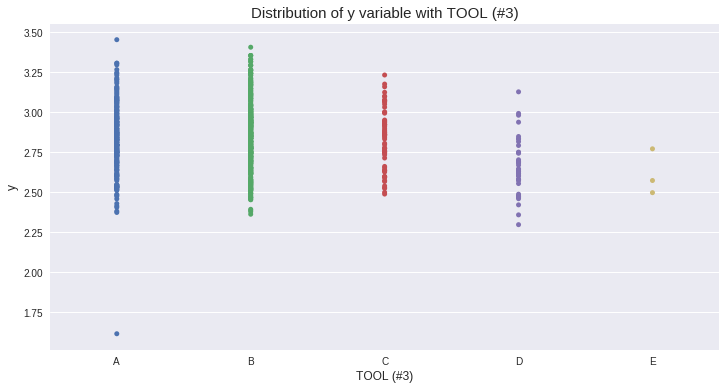

In [24]:
var_name = strs[11]
col_order = np.sort(train_df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.stripplot(x=var_name, y=train_df.columns[-1], data=train_df, order=col_order)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.show()

In [36]:
def dict2list(dic:dict):
    ''' 将字典转化为列表 '''
    keys = dic.keys()
    vals = dic.values()
    lst = [(key, val) for key, val in zip(keys, vals)]
    return lst

def LastRemainJudge(column):
    unique = set(column)
    uf = {}
    for u in unique:
        uf[u] = 0
    for c in column:
        uf[c] += 1
    sl = sorted(dict2list(uf), key = lambda x:x[1], reverse=True)
    x = sl[0][1]/len(column)
    sl = np.array(sl)
    if x < 0.8:
        #print(sl[:, 1]/len(column))
        return True
    else:
        return False

def ColumnsNormalization(data):
    for n in data.columns:
        m1 = np.mean(data[n])
        s1 = np.std(data[n])
        assert s1 > 0
        data[n] = (data[n] - m1) / s1
        return data

def OneHotColumns(train1, dfX, ints):
    remains1 = []
    remains2 = []
    tobedrop = []

    for n in ints:
        lu1 = len(train1[n].unique())
        lu2 = len(dfX[n].unique())
        if lu1 < 10 and lu1 > 1:
            remains1.append(n)
        if lu2 < 10 and lu2 > 1:
            remains2.append(n)
        if lu1 != lu2:
            tobedrop.append(n)

    #print(len(remains1), len(remains2), len(tobedrop))

    toberemain = list(set(remains1) & set(remains2) - set(tobedrop))
    #print(len(toberemain))
    lm1 = []
    lm2 = []
    for n in toberemain:
        if LastRemainJudge(train1[n]):
            lm1.append(n)
        if LastRemainJudge(dfX[n]):
            lm2.append(n)
    #print(len(lm1), len(lm2), len(set(lm1) & set(lm2)))
    dfx_onehot_n = list(set(lm1) & set(lm2))
    dfx_onehot = dfX[dfx_onehot_n]
    #print("shape of part of tobe onehot columns", dfx_onehot.shape)
    ohnames = dfx_onehot.columns
    for i in range(len(ohnames)):
        n = ohnames[i]
        tmp = pd.get_dummies(dfx_onehot[n], prefix='onehot_' + str(i))
        dfx_onehot = pd.concat([dfx_onehot, tmp], axis=1)
    dfx_onehot.drop(ohnames, axis=1, inplace=True)
    #print("after onehot and drop the raw columns", dfx_onehot.shape)
    return dfx_onehot

def YearColumns(dfx_year, drop_firststand=True):
    year_n = dfx_year.columns
    standardlen = len(str(dfx_year[year_n[0]][0]))
    for i in range(1, len(year_n)):
        l = len(str(dfx_year[year_n[i]][0]))
        bias = standardlen - l
        b10 = 1
        if bias > 0:
            for j in range(bias):
                b10 *= 10
                # dfx_year[year_n[i]] /= 10
        elif bias < 0:
            for j in range(-bias):
                b10 /= 10
                # dfx_year[year_n[i]] *= 10
        if b10 != 1:
            dfx_year[year_n[i]] *= b10
        dfx_year[year_n[i]] = dfx_year[year_n[i]] - dfx_year[year_n[0]]
    dfx_time = (dfx_year - np.mean(dfx_year)) / np.std(dfx_year)
    #print("shape of time", dfx_time.shape)
    if drop_firststand:
        dfx_time = dfx_time[dfx_time.columns[1:]]
        #print("shape of time after drop", dfx_time.shape)
    return dfx_time

def FloatSameColumnDrop(dfx_float):
    means = []
    stds = []
    drop_names = []
    names = dfx_float.columns
    for n in names:
        c = dfx_float[n]
        r = c[c.notnull()]
        tmpm = np.mean(r)
        tmps = np.std(r)
        means.append(tmpm)
        stds.append(tmps)
        if tmps == 0:
            drop_names.append(n)
    #print(len(set(means)), len(set(stds)))
    #print(len(drop_names))
    if len(drop_names) > 0:
        dfx_float.drop(drop_names, axis=1, inplace=True)
        #print("drop the data that has std of neo", dfx_float.shape)
    names = dfx_float.columns
    added = set()
    sames = []
    for i in range(len(names)):
        tmpsl = []
        tmpsl.append(i)
        for j in range(i + 1, len(names)):
            if means[i] == means[j] and stds[i] == stds[j]:
                if i not in added:
                    added.add(i)
                if j not in added:
                    added.add(j)
                    tmpsl.append(j)
        if len(tmpsl) > 1:
            sames.append(tmpsl)
    #print(len(sames))
    names = dfx_float.columns
    drop_names = []
    for i in sames:
        for j in i[1:]:
            drop_names.append(names[j])
    #print(len(drop_names))
    if len(drop_names) > 0:
        dfx_float.drop(drop_names, axis=1, inplace=True)
        #print("drop the data that has same distribution", dfx_float.shape)
    # fix the null columns
    names = dfx_float.columns
    for n in names:
        c = dfx_float[n]
        r = c[c.notnull()]
        tmpm = np.mean(r)
        tmps = np.std(r)
        assert tmps > 0
        dfx_float[n][c.isnull()] = tmpm
    #print("after fill the nan", np.sum(dfx_float.isnull().values))

    # get the log1p features
    mid =dfx_float - np.min(dfx_float) + 1
    trainx_log1p = np.log1p(mid)
    del mid
    #print("nan of log1p columns", np.sum(trainx_log1p.isnull().values))
    trainx_log1p = ColumnsNormalization(trainx_log1p)
    #print("float columns has been transferred into log1p columns")
    return trainx_log1p

def FloatColumns(train1, dfX):
    float_n = []
    names = dfX.columns
    dts = dfX.dtypes
    for i in range(len(names)):
        n = names[i]
        d = dts[i]
        if 'float' in str(d):
            float_n.append(n)

    dfx_float = dfX[float_n]
    #print("float columns", dfx_float.shape)
    # manipulate it
    drop_names = []
    names = dfx_float.columns
    for n in names:
        x = np.sum(dfx_float[n].isnull())
        if x > 500:
            drop_names.append(n)
    #print(len(drop_names))
    if len(drop_names) > 0:
        dfx_float.drop(drop_names, axis=1, inplace=True)
        #print("after drop too many nulls", dfx_float.shape)
    return FloatSameColumnDrop(dfx_float)

# drop_co='m':mean; 's':std
def DataManipulation(train1, testA1, testB1, drop_ratio=0.1, drop_co='m'):
    # the data shall drop id first as default
    # drop out the columns that distribute too different between train and testA
    names = train1.columns
    dts = train1.dtypes
    drop_names = []
    year = []
    ratio = drop_ratio
    for i in range(len(names)):
        n = names[i]
        tp = dts[i]
        trd = train1[n]
        ted = testA1[n]
        if 'object' == str(tp):
            continue
        else:
            misstr = np.sum(trd.isnull()) / 800
            misste = np.sum(ted.isnull()) / 300
            if np.abs(misstr - misste) > ratio:
                drop_names.append(n)
            else:
                if 'int' in str(tp):
                    if str(train1[n][0])[:4] == '2017' and str(train1[n][799])[:4] == '2017':
                        year.append(n)
                else:
                    trrd = trd[trd.notnull()]
                    terd = ted[ted.notnull()]
                    m1 = np.mean(trrd)
                    s1 = np.std(trrd)
                    m2 = np.mean(terd)
                    s2 = np.std(terd)
                    if drop_co == 'm':
                        if np.abs(m1 - m2) > ratio * np.abs(m1) and np.abs(s1 - s2) > ratio * np.abs(s1):
                            drop_names.append(n)
                    elif drop_co == 's':
                        if np.abs(m1 - m2) > ratio * np.abs(s1) and np.abs(s1 - s2) > ratio * np.abs(s1):
                            drop_names.append(n)
    #print(len(drop_names))
    #print(len(year))
    # drop the select columns
    train1.drop(drop_names, axis=1, inplace=True)
    testA1.drop(drop_names, axis=1, inplace=True)
    testB1.drop(drop_names, axis=1, inplace=True)

    names = train1.columns
    dfs = train1.dtypes
    # ints or strings
    ints = []
    for i in range(len(names)):
        if 'int' in str(dfs[i]) or 'object' in str(dfs[i]):
            ints.append(names[i])
    #print(len(ints))
    df_X = pd.concat([train1, testA1, testB1], axis=0)
    dfx_year = df_X[year]

    # get the log1p from floats
    #print("float columns manipulation")
    dfx_log1p = FloatColumns(train1, df_X)
    #print("float over")
    # manipulate one_hot columns from int columns
    #print("int to onehot start")
    dfx_onehot = OneHotColumns(train1, df_X, ints)
    #print("int2oh over")
    # manipulate the years
    dfx_time = YearColumns(dfx_year)
    #print("after manipulate")

    return dfx_log1p, dfx_onehot, dfx_time


In [27]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
def MSE(y_raw, y_pred):
    r = np.mean(np.square(y_raw-y_pred))
    #print(r)
    return r

In [29]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [30]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, random_state=2018)
def get_oof(rgr, xtrain, ytrain, xtest, lenot, lenoe):
    oof_train = np.zeros((lenot,))
    oof_test = np.zeros((lenoe,))
    oof_test_skf = np.empty((5, lenoe))
    for i, (train_index, test_index) in enumerate(kf.split(xtrain)):
        kf_xtrain = xtrain[train_index]
        kf_ytrain = ytrain[train_index]
        kf_xtest = xtrain[test_index]
        rgr.fit(kf_xtrain, kf_ytrain)
        oof_train[test_index] = rgr.predict(kf_xtest)
        oof_test_skf[i, : ] = rgr.predict(xtest)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [ ]:
trny = train_y[train_y>1.8]
print(trny.shape)
co = ['m', 's']
for i in range(1, 100):
    dr = 0.01*i
    for c in co:
        dfx_log1p, dfx_onehot, dfx_time = DataManipulation(train_df, test1_df, test2_df, drop_ratio=dr, drop_co=c)
        ndfx = pd.concat([dfx_log1p, dfx_onehot, dfx_time], axis=1)
        trndfx = ndfx[:800]
        trndfx = trndfx[train_y>1.8]
        results = []
        for i in range(100):
            subxtrain, subxval, subytrain, subyval = train_test_split(trndfx.values, trny.values, test_size=0.2, random_state=i)
    
            xgb = XGBRegressor()
            xgb.fit(subxtrain, subytrain)
            test1_pred = xgb.predict(subxval)
            t = MSE(test1_pred, subyval)
            results.append(t)
        print(dr, c, np.mean(results), np.std(results), np.max(results), np.min(results))

(799,)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.01 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.01 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.02 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.02 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.03 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.03 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.04 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.04 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.05 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.05 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.06 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.06 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.07 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.07 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.08 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.08 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.09 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.09 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.1 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.1 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.11 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.11 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.12 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.12 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.13 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.13 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.14 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.14 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.15 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.15 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.16 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.16 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.17 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.17 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.18 m 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 

0.18 s 0.0197915368566 0.002350196318 0.0248899477575 0.0142568104502


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 